In [1]:
import sys
sys.path.append('/home/decker/lab433')

from datetime import datetime

from synoptic import MODEL

from metpy.units import units
from metpy.constants import dry_air_gas_constant as R
from metpy.io import GempakGrid
import metpy.calc as mpcalc
from metpy.plots import FilledContourPlot, MapPanel, PanelContainer, ContourPlot, BarbPlot
import numpy as np
import xarray as xr

In [2]:
gem_file_name = MODEL + 'nam/24101612_nam211.gem'
gem_file = GempakGrid(gem_file_name)
plot_time = datetime(2024, 10, 18, 0)

In [3]:
pres1 = 500
pres2 = 900

htpres1 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=pres1)[0]
upres1 = gem_file.gdxarray(parameter='UREL', date_time=plot_time, level=pres1)[0]
vpres1 = gem_file.gdxarray(parameter='VREL', date_time=plot_time, level=pres1)[0]

htpres2 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=pres2)[0]
upres2 = gem_file.gdxarray(parameter='UREL', date_time=plot_time, level=pres2)[0]
vpres2 = gem_file.gdxarray(parameter='VREL', date_time=plot_time, level=pres2)[0]

htpres1 = htpres1 * units('m')
upres1 = upres1 * units('m/s')
vpres1 = vpres1 * units('m/s')

htpres2 = htpres2 * units('m')
upres2 = upres2 * units('m/s')
vpres2 = vpres2 * units('m/s')

thickness = htpres1.squeeze(dim='pres') - htpres2.squeeze(dim='pres')

thickness = mpcalc.smooth_gaussian(thickness, 16)
htpres1 = mpcalc.smooth_gaussian(htpres1, 16)
htpres2 = mpcalc.smooth_gaussian(htpres2, 16)
upres1 = mpcalc.smooth_gaussian(upres1, 16)
vpres1 = mpcalc.smooth_gaussian(vpres1, 16)
upres2 = mpcalc.smooth_gaussian(upres2, 16)
vpres2 = mpcalc.smooth_gaussian(vpres2, 16)

up1_geo, vp1_geo = mpcalc.geostrophic_wind(htpres1)
up2_geo, vp2_geo = mpcalc.geostrophic_wind(htpres2)

relvor_pres1 = mpcalc.vorticity(up1_geo, vp1_geo)
relvor_pres2 = mpcalc.vorticity(up2_geo, vp2_geo)

mean_vorticity = (relvor_pres1.squeeze(dim='pres') + relvor_pres2.squeeze(dim='pres')) / 2

In [4]:
pVor = FilledContourPlot()
pVor.data = mean_vorticity
pVor.time = plot_time
pVor.contours = list(range(0, 22, 2))
pVor.colorbar = 'horizontal'
pVor.colormap = 'coolwarm'
pVor.scale = 1e5

thicknessPlot = ContourPlot()
thicknessPlot.data = thickness
thicknessPlot.time = plot_time
thicknessPlot.contours = range(0,1100,4)
thicknessPlot.linecolor = 'black'
thicknessPlot.linestyle = 'solid'
thicknessPlot.clabels = True
thicknessPlot.plot_units = 'dam'

panel1 = MapPanel()
panel1.area = [-100, -70, 25, 50]
panel1.projection = 'lcc'
panel1.layers = ['states', 'coastline', 'borders']
panel1.title = f'Positive mean geostrophic relative vorticity between 900mb and 500 mb and thickness at {plot_time}'
panel1.layout = (2, 2, 1)
panel1.plots = [pVor, thicknessPlot]

In [5]:
p1 = 500
p2 = 900

delta_p = p2 - p1

htp2 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=p2)[0]
htp2 = htp2 * units('m')

htp1 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=p1)[0]
htp1 = htp1 * units('m')

htp2 = mpcalc.smooth_gaussian(htp2, 16)
htp1 = mpcalc.smooth_gaussian(htp1, 16)

(Vg1_u, Vg1_v) = mpcalc.geostrophic_wind(htp1)
(Vg2_u, Vg2_v) = mpcalc.geostrophic_wind(htp2)
Vg1_u = Vg1_u.rename('u')
Vg1_v = Vg1_v.rename('v')
Vg1 = xr.merge([Vg1_u,Vg1_v])
Vg2_u = Vg2_u.rename('u')
Vg2_v = Vg2_v.rename('v')
Vg2 = xr.merge([Vg2_u,Vg2_v])
Vt = Vg1 - Vg2

fo =  mpcalc.coriolis_parameter(Vt['latitude'])

Vg1u = Vg1_u.squeeze(dim='pres')
Vg2u = Vg2_u.squeeze(dim='pres')
Vg1v = Vg1_v.squeeze(dim='pres')
Vg2v = Vg2_v.squeeze(dim='pres')
Cg1 = mpcalc.vorticity(Vg1u, Vg1v)
Cg2 = mpcalc.vorticity(Vg2u, Vg2v)

Cg = (Cg1 + Cg2)/2

Vti = Vg1_u.squeeze(dim='pres') - Vg2_u.squeeze(dim='pres')
Vtj = Vg1_v.squeeze(dim='pres') - Vg2_v.squeeze(dim='pres')

advection = mpcalc.advection(Cg, Vti, Vtj)

F = (((2 * fo)/delta_p) * (advection))

/tmp/ipykernel_25741/2600512723.py:39: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  advection = mpcalc.advection(Cg, Vti, Vtj)


In [6]:
d1 = FilledContourPlot()
d1.data = F
d1.time = plot_time
d1.contours = list(range(0, 24, 2))
d1.colorbar = 'horizontal'
d1.colormap = 'coolwarm'
d1.scale = 5e15

panel2 = panel1.copy()
panel2.title = f'Sutcliffe term from 900mb - 500mb at {plot_time}'
panel2.layout = (2, 2, 2)
panel2.plots = [d1]

In [7]:
pres = 700
pres = pres * units('hPa')
ht = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=pres.m)[0]
ht = ht * units('m')
temp = gem_file.gdxarray(parameter='TMPK', date_time=plot_time, level=pres.m)[0]
temp = temp * units('K')

ht = mpcalc.smooth_gaussian(ht, 16)
temp = mpcalc.smooth_gaussian(temp, 16)

ug, vg = mpcalc.geostrophic_wind(ht)
Q_i, Q_j = mpcalc.q_vector(ug, vg, temp, pres)
Q_i = Q_i.rename('i')
Q_j = Q_j.rename('j')
Q_vector = xr.merge([Q_i, Q_j])

F_Q = -2 * (mpcalc.divergence(Q_i, Q_j))

In [8]:
fill = FilledContourPlot()
fill.data = F_Q
fill.time = plot_time
fill.contours = range(0, 16, 1)
fill.scale = 5e17
fill.colormap = 'coolwarm'
fill.colorbar = 'horizontal'

barbs = BarbPlot()
barbs.data = Q_vector
barbs.scale = 2e13
barbs.time = plot_time
barbs.field = ['i', 'j']
barbs.earth_relative = False
barbs.skip = (3, 3)

panel3 = panel1.copy()
panel3.title = f'Q Vectors and Convergence at {pres} at {plot_time}'
panel3.layout = (2, 2, 3)
panel3.plots = [fill, barbs]

In [9]:
pressure = 700 

ht700 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=700)[0]
ht700 = ht700 * units('m')
ht700 = mpcalc.smooth_gaussian(ht700, 16)
htpressure = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=pressure)[0] * units('m')

geoV0u, geoV0v = mpcalc.geostrophic_wind(htpressure)
geoV0u = geoV0u.rename('u')
geoV0v = geoV0v.rename('v')
geopressure = xr.merge([geoV0u,geoV0v])

tmpk = gem_file.gdxarray(parameter='TMPK', date_time=plot_time, level=pressure)[0]
hght = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=pressure)[0]

tmpk_smooth = mpcalc.smooth_gaussian(tmpk, 16)
hght_smooth = mpcalc.smooth_gaussian(hght, 16)

geoV0u, geoV0v = mpcalc.geostrophic_wind(hght_smooth)
geoV0u = geoV0u.rename('u')
geoV0v = geoV0v.rename('v')

geopressure = xr.merge([geoV0u,geoV0v])

tmpk = tmpk * units('degK')
hght = hght * units('m')

temp_adv = mpcalc.advection(tmpk_smooth,geoV0u,geoV0v)
laplacian_temp = mpcalc.laplacian(temp_adv.squeeze(['time','pres']) )
laplacian = -R / pressure * laplacian_temp
total = laplacian

p1 = 850
p2 = 500
f0 = 1.028e-4

htp1 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=p1)[0]
up1 = gem_file.gdxarray(parameter='UREL', date_time=plot_time, level=p1)[0]
vp1 = gem_file.gdxarray(parameter='VREL', date_time=plot_time, level=p1)[0]

htp2 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=p2)[0]
up2 = gem_file.gdxarray(parameter='UREL', date_time=plot_time, level=p2)[0]
vp2 = gem_file.gdxarray(parameter='VREL', date_time=plot_time, level=p2)[0]

htp1 = htp1 * units('m')
up1 = up1 * units('m/s')
vp1 = vp1 * units('m/s')

htp2 = htp2 * units('m')
up2 = up2 * units('m/s')
vp2 = vp2 * units('m/s')

htp1 = mpcalc.smooth_gaussian(htp1, 16)
htp2 = mpcalc.smooth_gaussian(htp2, 16)
up1 = mpcalc.smooth_gaussian(up1, 16)
vp1 = mpcalc.smooth_gaussian(vp1, 16)
up2 = mpcalc.smooth_gaussian(up2, 16)
vp2 = mpcalc.smooth_gaussian(vp2, 16)

up1_geo, vp1_geo = mpcalc.geostrophic_wind(htp1)
up2_geo, vp2_geo = mpcalc.geostrophic_wind(htp2)

absvor_p1 = mpcalc.absolute_vorticity(up1_geo, vp1_geo)
absvor_p2 = mpcalc.absolute_vorticity(up2_geo, vp2_geo)

advp1 = mpcalc.advection(absvor_p1, up1_geo, vp1_geo)
advp2 = mpcalc.advection(absvor_p2, up2_geo, vp2_geo)

term1 = f0 / ((p2-p1))
term2 = advp1.squeeze('pres') - advp2.squeeze('pres')
finalterm = term1 * term2

total_no_units = total.metpy.dequantify()
finalterm_no_units = finalterm.metpy.dequantify()

omega = total_no_units + finalterm_no_units
omega = omega * units('microbar/second')
omega = mpcalc.smooth_gaussian(omega, 16)

In [10]:
heights = ContourPlot()
heights.data = ht700
heights.time = plot_time
heights.contours = list(range(0,600,3))
heights.linecolor = 'black'
heights.linestyle = 'solid'
heights.clabels = True
heights.plot_units = 'dam'

omegaNeg = FilledContourPlot()
omegaNeg.data = omega
omegaNeg.time = plot_time
omegaNeg.contours = list(range(0, 22, 2))
omegaNeg.scale = 1e16
omegaNeg.colormap = 'coolwarm'
omegaNeg.colorbar = 'horizontal'

panel4 = panel1.copy()
panel4.title = f'Negative Omega and Heights at 700mb at {plot_time}'
panel4.plots = [heights, omegaNeg]
panel4.layout = (2, 2, 4)

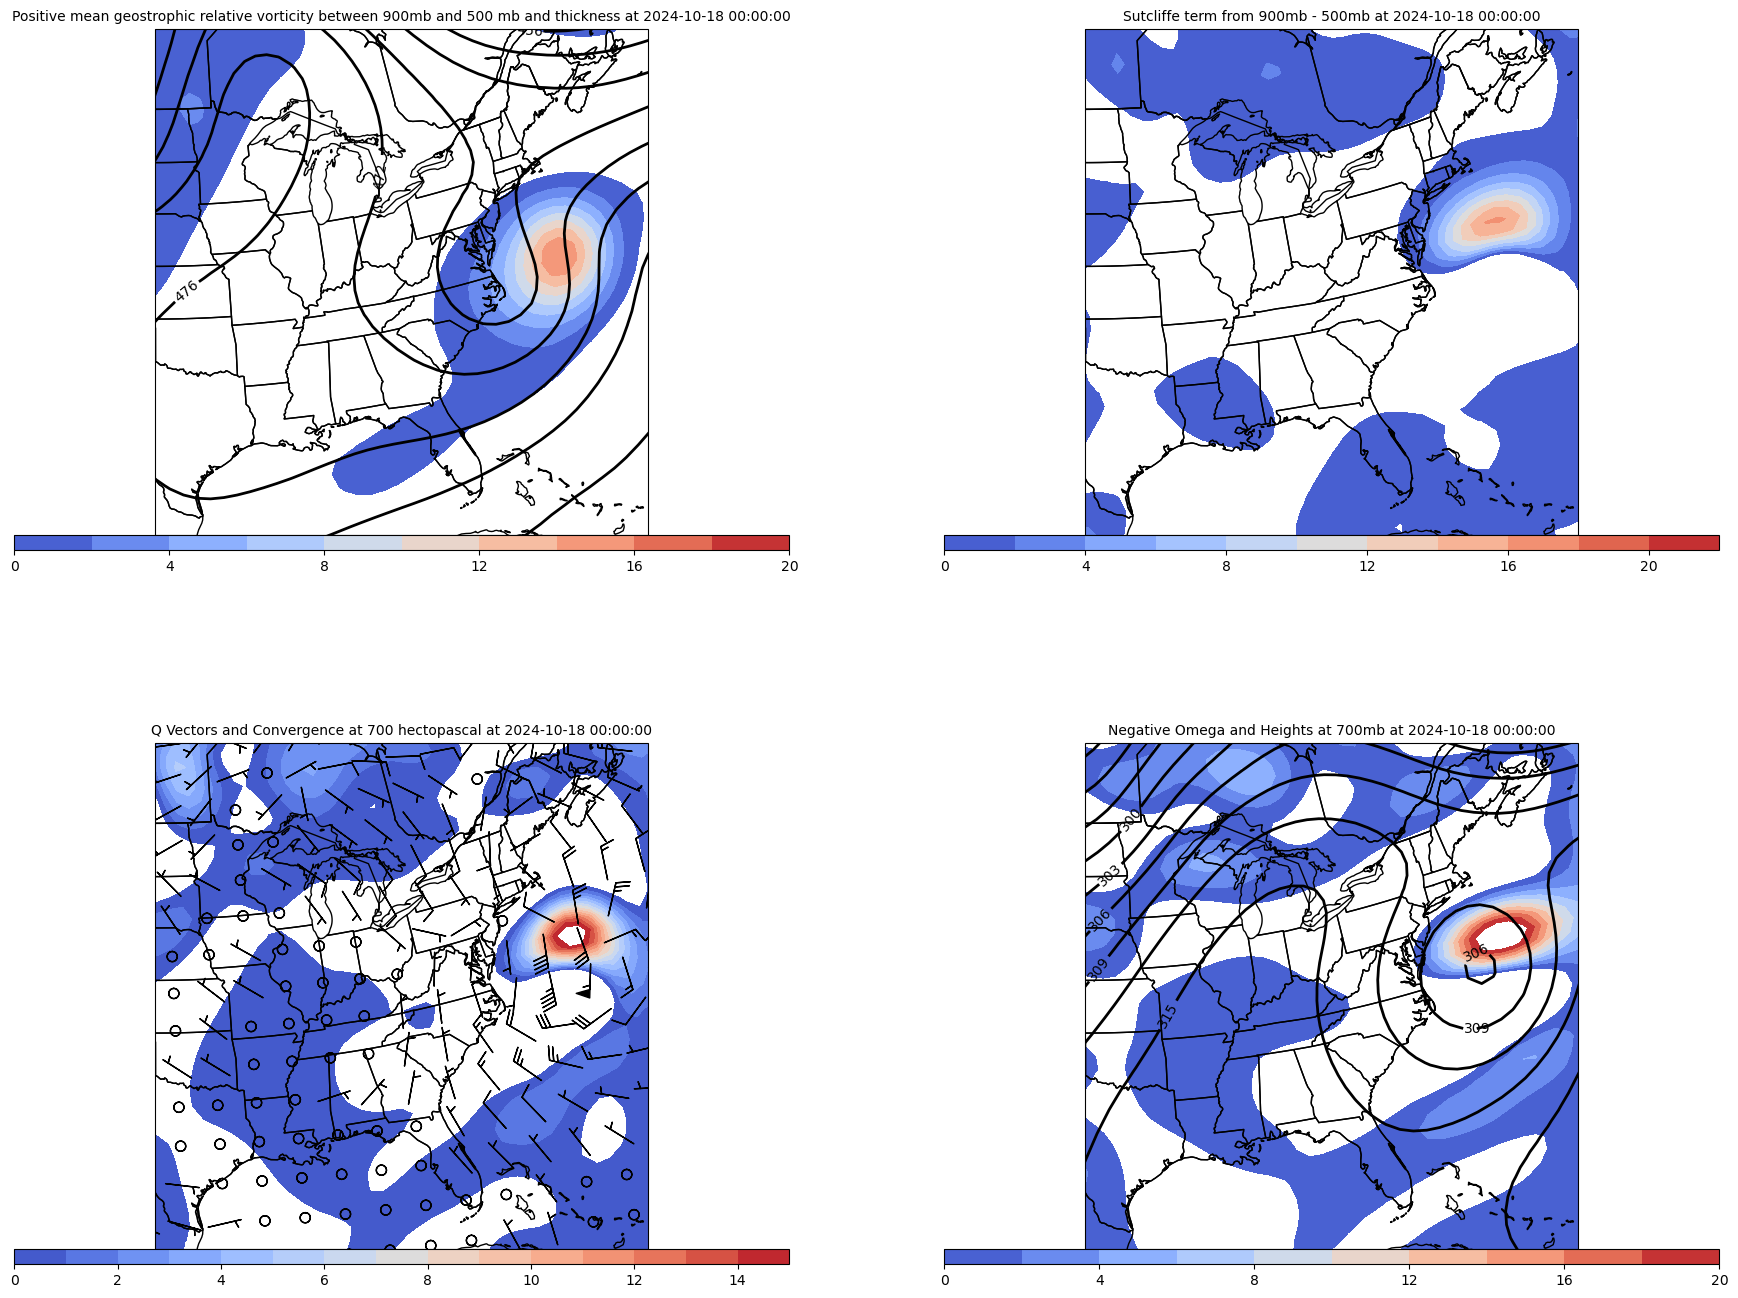

In [11]:
pc = PanelContainer()
pc.size = (22,17)
pc.panels = [panel1, panel2, panel3, panel4]
pc.show()